# Homework 3

In [5]:
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

Files already downloaded and verified
[1,   195] loss: 4.222
Accuracy of the network on the test set: 10 %
Accuracy of the network on the test set: 10 %
[2,   195] loss: 3.802
Accuracy of the network on the test set: 13 %
Accuracy of the network on the test set: 13 %
[3,   195] loss: 3.638
Accuracy of the network on the test set: 16 %
Accuracy of the network on the test set: 16 %
[4,   195] loss: 3.534
Accuracy of the network on the test set: 17 %
Accuracy of the network on the test set: 17 %
[5,   195] loss: 3.445
Accuracy of the network on the test set: 18 %
Accuracy of the network on the test set: 18 %
[6,   195] loss: 3.371
Accuracy of the network on the test set: 19 %
Accuracy of the network on the test set: 19 %
[7,   195] loss: 3.299
Accuracy of the network on the test set: 19 %
Accuracy of the network on the test set: 19 %
[8,   195] loss: 3.237
Accuracy of the network on the test set: 21 %
Accuracy of the network on the test set: 21 %
[9,   195] loss: 3.174
Accuracy of the net

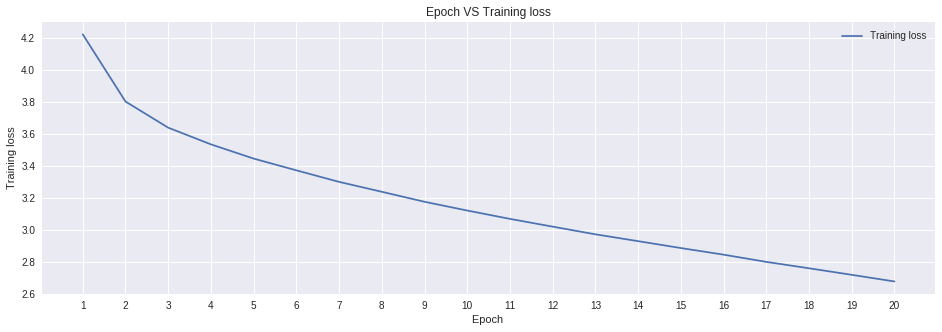

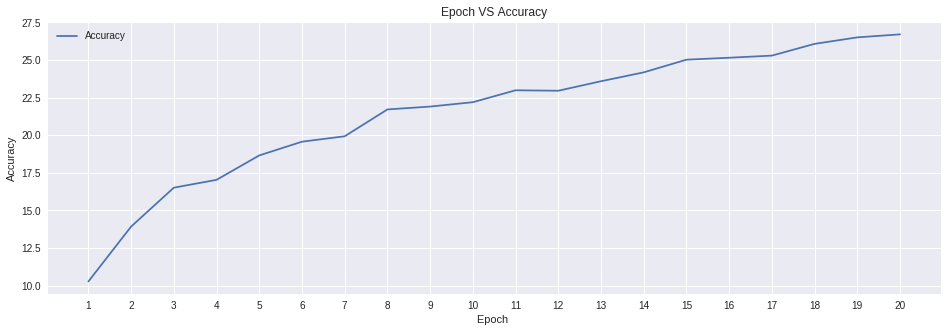

In [6]:
%matplotlib inline
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def plot_kernel(model):
    model_weights = model.state_dict()
    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(model_weights['conv1.weight']):
    #print(filt[0, :, :])
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt[0, :, :], cmap="gray")
        plt.axis('off')
    
    plt.show()

def plot_kernel_output(model,images):
    fig1 = plt.figure()
    plt.figure(figsize=(1,1))
    
    img_normalized = (images[0] - images[0].min()) / (images[0].max() - images[0].min())
    plt.imshow(img_normalized.numpy().transpose(1,2,0))
    plt.show()
    output = model.conv1(images)
    layer_1 = output[0, :, :, :]
    layer_1 = layer_1.data

    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(layer_1):
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
    plt.show()

def test_accuracy(net, dataloader):
  ########TESTING PHASE###########
  
    #check accuracy on whole test set
    correct = 0
    total = 0
    net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (
    accuracy))
    return accuracy

    
n_classes = 100 
# function to define an old style fully connected network (multilayer perceptrons)
class old_nn(nn.Module):
    def __init__(self):
        super(old_nn, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
      
      
#function to define the convolutional network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x

      ####RUNNING CODE FROM HERE:
      
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
        #transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4,drop_last=True)

dataiter = iter(trainloader)

#create the old style NN network
net = old_nn()
net = net.cuda()

criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)

########TRAINING PHASE###########
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!
list_accuracy=[]
list_loss=[]
n_epochs = 20
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / n_loss_print))
            list_loss.append(running_loss / n_loss_print)
            running_loss = 0.0
    list_accuracy.append(test_accuracy(net,testloader))
    test_accuracy(net,testloader)
print('Finished Training')

# Plot of the loss curve
epoch = np.arange(1, 21)
fig,ax1=plt.subplots(ncols=1,figsize=(16,5))
ax1.plot(epoch, list_loss, label = 'Training loss')
ax1.legend()
plt.title('Epoch VS Training loss')
plt.xlabel('Epoch ')
plt.ylabel('Training loss')
plt.xticks(epoch)
plt.show()

# Plot of the accuracy curve
epoch = np.arange(1, 21)
fig,ax1=plt.subplots(ncols=1,figsize=(16,5))
ax1.plot(epoch, list_accuracy, label = 'Accuracy')
ax1.legend()
plt.title('Epoch VS Accuracy')
plt.xlabel('Epoch ')
plt.ylabel('Accuracy')
plt.xticks(epoch)
plt.show()



The accuracy grows after each epoch and the loss go up after each epoch. I expected this because the goal of neural network is to minimize the loss value with respect to the model's parameters by changing the weight vector values using backpropagation.
The accuracy at the last epoch is the greater as I expected.

Files already downloaded and verified
Files already downloaded and verified
[1,   195] loss: 3.799
Accuracy of the network on the test set: 21 %
Accuracy of the network on the test set: 21 %
[2,   195] loss: 3.094
Accuracy of the network on the test set: 28 %
Accuracy of the network on the test set: 28 %
[3,   195] loss: 2.738
Accuracy of the network on the test set: 32 %
Accuracy of the network on the test set: 32 %
[4,   195] loss: 2.494
Accuracy of the network on the test set: 36 %
Accuracy of the network on the test set: 36 %
[5,   195] loss: 2.294
Accuracy of the network on the test set: 37 %
Accuracy of the network on the test set: 37 %
[6,   195] loss: 2.135
Accuracy of the network on the test set: 40 %
Accuracy of the network on the test set: 40 %
[7,   195] loss: 1.998
Accuracy of the network on the test set: 42 %
Accuracy of the network on the test set: 42 %
[8,   195] loss: 1.865
Accuracy of the network on the test set: 42 %
Accuracy of the network on the test set: 42 %
[9, 

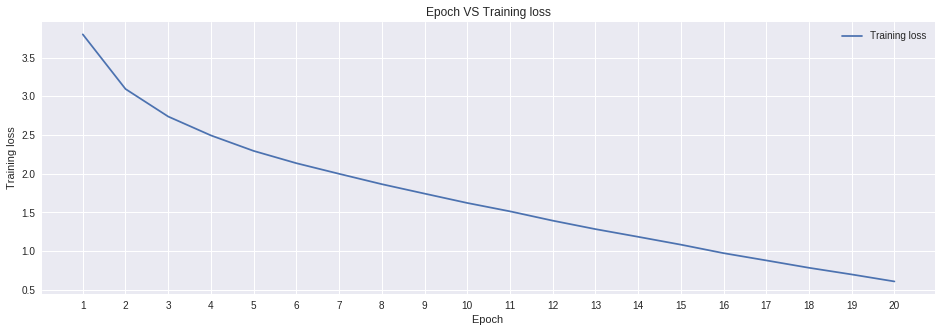

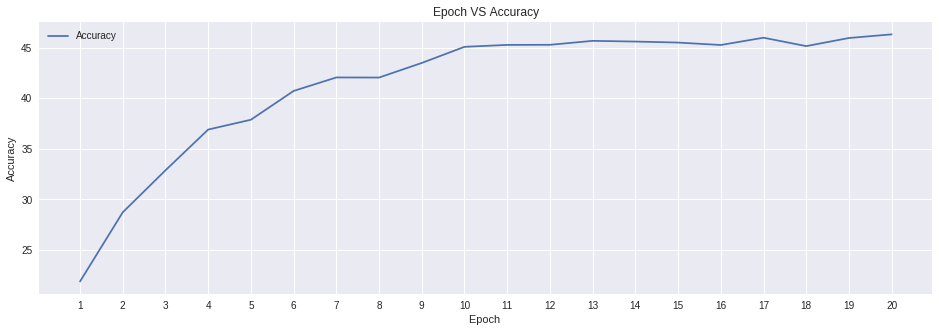

In [0]:
#CNN with number of convolutional filters equal to 128/128/128/256 used in point 3/6
"""class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x
  """

#CNN with number of convolutional filters equal to 256/256/256/512 used in point 3/6
"""class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 256, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(512 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x
 """

#CNN with number of convolutional filters equal to 512/512/512/1024 used in 3/6
"""class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 512, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(1024 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x
"""
#CNN with Batch Normalization used in point 4/6 4a)
"""class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv1_bn=nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv2_bn=nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3_bn=nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.conv_final_bn=nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

        
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.pool(self.conv_final_bn(self.conv_final(x))))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x
 """

#CNN with Batch Normalization+FC1 wider used in point 4/6 4b)
"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv1_bn=nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv2_bn=nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3_bn=nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.conv_final_bn=nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 4 * 4, 8192)
        self.fc2 = nn.Linear(8192, n_classes) #last FC for classification 

        
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.pool(self.conv_final_bn(self.conv_final(x))))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x
"""
#CNN with Batch Normalization+FC1 wider used in point 4/6 4c)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv1_bn=nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv2_bn=nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3_bn=nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.conv_final_bn=nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.dropout=nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

        
         
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.pool(self.conv_final_bn(self.conv_final(x))))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.dropout(x)
        x = self.fc2(x)
        return x

      
        ####RUNNING CODE FROM HERE:
  ####RUNNING CODE FROM HERE:
      
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
     #The line below is the code for RandomHorizontalFlip as required in point 5/6 4a) 
     #transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     #The two lines below are the code for Random Crop as required in point 5/6 4b)
     #transforms.Resize((40,40)),
     #transforms.RandomCrop((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4,drop_last=True)


dataiter = iter(trainloader)


#net used in point 2/6
#net = CNN()
net=CNN()
net = net.cuda()
criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)


  

########TRAINING PHASE###########
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!
list_accuracy_1=[]
list_loss_1=[]
n_epochs = 20
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / n_loss_print))
            list_loss_1.append(running_loss / n_loss_print)
            running_loss = 0.0
    list_accuracy_1.append(test_accuracy(net,testloader))
    test_accuracy(net,testloader)
print('Finished Training')


# Plot loss curve
epoch = np.arange(1, 21)
fig,ax1=plt.subplots(ncols=1,figsize=(16,5))
ax1.plot(epoch, list_loss_1, label = 'Training loss')
ax1.legend()
plt.title('Epoch VS Training loss')
plt.xlabel('Epoch ')
plt.ylabel('Training loss')
plt.xticks(epoch)
plt.show()


# Plot accuracy curve
epoch = np.arange(1, 21)
fig,ax1=plt.subplots(ncols=1,figsize=(16,5))
ax1.plot(epoch, list_accuracy_1, label = 'Accuracy')
ax1.legend()
plt.title('Epoch VS Accuracy')
plt.xlabel('Epoch ')
plt.ylabel('Accuracy')
plt.xticks(epoch)
plt.show()



- 2/6

Using the simple CNN I obtain a sligthly better accuracy than when I use the fully connected network. Probably, this behaviour is due to the fact that in this CNN I use more layers that permits to identify and extract the best features from the image and then I have a better classificiation of the images. With the simple CNN provided I obtain 29% of accuracy.

- 3/6

If I change the number of convolutional filter I obtain that increasing the number of convolutional filters I have a slightly better accuracy. Probably a big amount of pixels are necessary for the network to recognize better the object. Thus using a greater number of convolutional filters we have a better accuracy.
I obtain that the better result in terms of accuracy is when I use 512/512/512/1024 number of convolutional filters.
About computational time and accuracy I get:

-8 minutes when I use 128/128/128/256 convolutional filters and final accuracy of 32%

-16 minutes when I use 256/256/256/512 convolutional filters and final accuracy of 34%

-45 minutes when I use 512/512/512/1024 convolutional filters and final accuracy of 36%

- 4/6

If I try to modify the previous CNN introducing Batch Normalization (BN) for every convolution layer I get a faster convergence(the loss go to zero after a few epochs) and an higher final test accuracy (43%) as I expected.
When I use BN + FC1 wider I get slightly increasing of the final test accuracy (44%) but the loss is going to zero so fast than when I  use only 4096 neurons for FC1. 
If I introduce BN+ Dropout 0.5 on FC1 I get a slightly increasing of  the final test accuracy (45%) but in this case I observe that the loss is not going to zero so fast as in the previous cases because with dropout some neurons at training time are dropped-out and we only keep all neurons at test time .

- 5/6

If I try to apply data augmentation techniques I get a better final accuracy and a faster convergence of loss to zero using Random Horizontal flipping (36% of final test accuracy  )compared to Random crop (33% of final test accuracy). Probably I get this result because Random Horizontal flipping technique fits better with my dataset and it permits to capture the features that are most important for correct classification of the images.


In [7]:
#6/6
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
       
        x = self.fc2(x)
        return x

       ####RUNNING CODE FROM HERE:
  ####RUNNING CODE FROM HERE:
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4,drop_last=True)

dataiter = iter(trainloader)


    

#for Residual Network:
net = models.resnet18(pretrained=True)
#net.fc = nn.Linear(512, n_classes) #changing the fully connected layer of the already allocated network
####

net = net.cuda()

criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)

########TRAINING PHASE###########
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!
list_accuracy_2=[]
list_loss_2=[]
n_epochs = 10
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / n_loss_print))
            list_loss_2.append(running_loss / n_loss_print)
            running_loss = 0.0
    list_accuracy_2.append(test_accuracy(net,testloader))
    test_accuracy(net,testloader)
print('Finished Training')

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 30949029.44it/s]


[1,   390] loss: 2.354
Accuracy of the network on the test set: 67 %
Accuracy of the network on the test set: 67 %
[2,   390] loss: 0.844
Accuracy of the network on the test set: 73 %
Accuracy of the network on the test set: 73 %
[3,   390] loss: 0.547
Accuracy of the network on the test set: 76 %
Accuracy of the network on the test set: 76 %
[4,   390] loss: 0.346
Accuracy of the network on the test set: 77 %
Accuracy of the network on the test set: 76 %
[5,   390] loss: 0.227
Accuracy of the network on the test set: 77 %
Accuracy of the network on the test set: 77 %
[6,   390] loss: 0.152
Accuracy of the network on the test set: 77 %
Accuracy of the network on the test set: 77 %
[7,   390] loss: 0.107
Accuracy of the network on the test set: 77 %
Accuracy of the network on the test set: 77 %
[8,   390] loss: 0.073
Accuracy of the network on the test set: 78 %
Accuracy of the network on the test set: 78 %
[9,   390] loss: 0.058
Accuracy of the network on the test set: 77 %
Accuracy of

Compared to the previous networks that I used, with ResNet18 I get the better accuracy and there is a great improving of the final test accuracy . This is due to the fact that using ResNet18 I increase the depth of the architecture. With 10 iteration I have that accuracy increase and the loss decrease at each iteration and I have a very good accuracy at the end of the last epoch.